In [ ]:
# This notebook will serve as a tutorial for implementing and using
# IGF, information gain filtration, which is a method proposed by Antonello et. al. 
# for more effective finetuning of pretrained models. 

# The tutorial follows three steps:

# 1) A dataset of pairs (X, IG(X)) is generated.
# 2) A secondary learner is created to infer a function approximation for IG using the dataset created in (1).
# 3) The learner created in (2) is used to inform the finetuning process. 
# We then generate a plot comparing the performance of IGF 
# compared to standard finetuing without any context filtering.

# Each stage of the process can alternatively be skipped with checkpoint files that are also included in the Github repo.

# What you will need:
# Download the tokenized version of the Wikitext dataset
# or another corpus that you would like to finetune on.

# Some parts of this script lifted from here:
# https://github.com/huggingface/transformers/blob/master/examples/run_glue.py

# Prerequisite libraries: 

import torch
import joblib
import random
import logging
import time
import sys
import numpy as np
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset)
from tqdm import tqdm, trange
from transformers import (AdamW, GPT2LMHeadModel, GPT2Tokenizer)
from transformers import get_linear_schedule_with_warmup
from torch.autograd import Variable
from torch.nn import functional as F
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt

# We use contexts of length 128 for this notebook for efficiency
# but this number can be changed as you like

CONTEXT_LEN = 128

In [ ]:
# This first cell handles the first step, generating a dataset of pairs (X, IG(X)).
# This is the most time consuming task, and can be skipped by using the provided
# pregenerated dataset of pairs. This takes awhile compared to the other steps.

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def compute_real_Q(test_data, model):
    '''Computes perplexity of the model on the objective set, test_data'''
    model.eval()
    eval_batch_size = 1
    device = "cpu"
    #device = next(model.parameters()).device
    context = torch.zeros((eval_batch_size, CONTEXT_LEN), dtype=torch.long, device=device)
    eval_sampler = SequentialSampler(test_data)
    eval_dataloader = DataLoader(test_data, sampler=eval_sampler, batch_size=eval_batch_size)
    eval_loss = 0.0
    nb_eval_examples = 0
    for batch in eval_dataloader:
        # pad
        context.zero_()
        for i in range(eval_batch_size):
            context[i, :] = batch[i]
        eval_loss += model(context, labels=context)[0].sum().item()
        nb_eval_examples += batch.size(0)
    eval_loss = eval_loss / nb_eval_examples
    perplexity = torch.exp(torch.tensor(eval_loss, device=device))
    model.train()
    return perplexity

def train(train_dataset, test_dataset, model, tokenizer,  max_steps, r_penalty, data_start):
    """ Train the model """
    # Initialize the model
    device = torch.device('cpu')
    train_sampler = RandomSampler(train_dataset)
    train_dataloader = DataLoader(train_dataset, sampler=train_sampler)

    t_total = max_steps
    num_train_epochs = max_steps // (len(train_dataset)) + 1
    past_Q = torch.tensor(0.0, device=device)
    logger.info("***** Running training *****")
    logger.info("  Num examples = %d", len(train_dataset))
    global_step = 0
    tr_lm_loss, logging_lm_loss = 0.0, 0.0
    tr_q_loss, logging_q_loss = 0.0, 0.0
    context = torch.zeros((1, CONTEXT_LEN), dtype=torch.long, device=device)
    loss = nn.MSELoss()
    model = GPT2LMHeadModel.from_pretrained('gpt2-medium', output_hidden_states=True)
    config = model.config
    torch.save(model.state_dict(), "gpt2_weights2.torch")

    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
         'weight_decay': 0.0},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
    lm_optimizer = AdamW(optimizer_grouped_parameters, lr=5e-5, eps=1e-8)
    first_time = True
    lm_scheduler = get_linear_schedule_with_warmup(lm_optimizer, 0, t_total)
    contexts = []
    past_perps = []
    real_perps = []
    past_perps2 = []
    features = []
    model.train()
    model.to(device)
    for story in train_dataset:
        for step, example in enumerate(story[0]):
            # Periodically save the stored (X, IG(X)) pairs
            if global_step % 1000 == 0 and global_step > 1:
                data = (contexts, past_perps, real_perps, past_perps2)
                data_final = []
                allp = []
                for i in range(len(data[1])):
                    allp.append(data[1][i] - data[2][i])
                    data_final.append((data[0][i], data[1][i] - data[2][i], data[3][i]))

                avg = np.array(allp).mean()
                std = np.array(allp).std()

                for i in range(len(data_final)):
                    data_final[i] = (data_final[i][0], (data_final[i][1] - avg) / std, data_final[i][2])
                joblib.dump(data_final, "IGF_values_gpt_med.jbl")
                del data_final
                del avg
                del std
                del allp
                del data
            if True:
                # Reset the model to the original pretrained GPT-2 weights after each iteration
                del model
                del optimizer_grouped_parameters
                del no_decay
                del lm_optimizer
                del lm_scheduler
                torch.cuda.empty_cache()
                model = GPT2LMHeadModel(config=config)
                model.load_state_dict(torch.load("gpt2_weights2.torch"))
                model.to(device)
                no_decay = ['bias', 'LayerNorm.weight']
                optimizer_grouped_parameters = [
                    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
                     'weight_decay': 0.0},
                    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
                     'weight_decay': 0.0}
                ]
                lm_optimizer = AdamW(optimizer_grouped_parameters, lr=5e-5, eps=1e-8)
                lm_scheduler = get_linear_schedule_with_warmup(lm_optimizer, 0, t_total)
                context = torch.zeros((1, CONTEXT_LEN), dtype=torch.long, device=device)
            torch.cuda.empty_cache()
            story2 = random.choice(train_dataset)
            # Skip articles if they aren't of sufficient length
            if len(story2[0]) < 1026:
                #print("skipped")
                continue
            start = random.randint(0, len(story2[0]) - CONTEXT_LEN - 1)
            context[0, :] = story2[0][start:start + CONTEXT_LEN]
            lm_optimizer.zero_grad()
            outputs = model(context, labels=context)
            lm_loss = outputs[0]
            # Compute perplexity of initial model
            if first_time:
                past_perp = compute_real_Q(test_dataset, model)
                first_time = False
            past_perp2 = compute_real_Q(context, model)
            model.train()
            lm_loss.backward()
            # Do LM backprop
            torch.nn.utils.clip_grad_norm_(model.parameters(), 3.0)
            lm_optimizer.step()
            lm_scheduler.step()  # Update learning rate schedule
            features = []
            # Compute perplexity after backpropogating on the selected context
            real_perp = compute_real_Q(test_dataset, model)
            if (global_step + 1) % 50 == 0:
                print("Number of Samples: ", global_step + 1)
            past_perps.append(past_perp.item())
            past_perps2.append(past_perp2.item())
            real_perps.append(real_perp.item())
            contexts.append(np.array(context.cpu()))
            del outputs
            del real_perp
            del context
            global_step += 1
            del lm_loss

            if max_steps > 0 and global_step > max_steps:
                break
        if max_steps > 0 and global_step > max_steps:
            break

    return global_step, tr_lm_loss / global_step





if __name__ == "__main__":
    #Generate objective set and training set
    data_start = 42
    # Designate the first 100 articles to be used as our objective set
    test_data = joblib.load("tokenized_stories_train_wikitext103.jbl")[:100]
    # The rest of the articles in the training set will be used to sample for finetuning
    train_data = joblib.load("tokenized_stories_train_wikitext103.jbl")[100:]
    set_seed(3)
    test_data_sliced = []
    # Randomly generate our objective set
    for test_example in test_data:
        if len(test_example[0]) > 1026:
            start = random.randint(0, len(test_example[0]) - CONTEXT_LEN - 1)
            test_data_sliced.append(test_example[0, start:start + CONTEXT_LEN])
    joblib.dump(test_data_sliced, "objective_set.jbl")
    set_seed(int(data_start))
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
    model = GPT2LMHeadModel.from_pretrained('gpt2', output_hidden_states=True)
    logger = logging.getLogger(__name__)
    train(train_data, test_data_sliced, model, tokenizer, 4000, torch.tensor(0.001), int(data_start))


In [ ]:
# This next cell handles the second step, which takes the generated (X, IG(X)) pairs and 
# generates a secondary learner that regresses the IG function.
# This can be evaluated using the pregeneated IGF_values.jbl file or the one generated in the
# cell above
import joblib

logger = logging.getLogger(__name__)


def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


def train2(dqn, train_dataset, max_steps, batch_size):
    """ Train the model """
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    # We will use the first 512 pairs from our dataset as a test set for 
    # our secondary learner and the rest to train
    test_dataset = train_dataset[:512]
    train_dataset = train_dataset[512:]

    train_sampler = RandomSampler(train_dataset)
    train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)
    test_sampler = SequentialSampler(test_dataset)
    test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=batch_size)

    # Train!
    logger.info("***** Running training *****")
    global_step = 0
    loss = nn.MSELoss()
    test_loss = nn.MSELoss(reduction='sum')
    dqn.to(device)
    q_optimizer = torch.optim.Adam(dqn.parameters(), lr=0.00001)

    dqn.train()

    epoch = 0

    best_test_loss = float('inf')
    # Iterate through batches until we've used max_steps batches
    while True:
        print('Epoch', epoch)
        tr_q_loss = 0.0
        dqn.train()
        for step, batch in enumerate(train_dataloader):
            context = batch[0].to(device)
            real_Q = batch[1].to(device)
            predicted_Q = dqn(context)
            q_optimizer.zero_grad()
            q_loss = loss(predicted_Q, real_Q.float())
            q_loss.backward()
            q_optimizer.step()
            tr_q_loss += q_loss.item()
            global_step += 1
            if max_steps > 0 and global_step > max_steps:
                break

        if max_steps > 0 and global_step > max_steps:
            break
        epoch += 1

        tr_q_loss /= step + 1

        dqn.eval()
        q_loss2 = 0.0
        sum_q2 = 0.0
        predicted = []
        actual = []
        # Compute performance of the secondary learner after this batch
        for step2, batch2 in enumerate(test_dataloader):
            features2 = batch2[0].to(device)
            real_Q2 = batch2[1].to(device)
            predicted_Q2 = dqn(features2)
            q_loss2 += test_loss(predicted_Q2, real_Q2).item()
            sum_q2 += torch.sum(predicted_Q2).item()
            for ei, i in enumerate(predicted_Q2.cpu().detach().numpy()):
                predicted.append(i.item())
            for ei, i in enumerate(real_Q2.cpu().detach().numpy()):
                actual.append(i.item())


        print('Avg. predicted test q:', sum_q2 / len(test_dataset))
        q_loss2 /= len(test_dataset)
        print("Train Loss: ", tr_q_loss)
        print("Test Loss: ", q_loss2)
        if q_loss2 < best_test_loss:
            # Save if test performance improves
            joblib.dump((predicted, actual), "pred_vs_actual.jbl")
            torch.save(dqn.state_dict(), 'dqn.bin')
            print('Saved!')
            best_test_loss = q_loss2

    return dqn


class DQN(nn.Module):
    '''Our secondary learner'''
    def __init__(self, embeddings):
        '''We use a simple convulotional network as our secondary learner'''
        super(DQN, self).__init__()
        self.embeddings = embeddings
        self.conv = nn.Conv1d(embeddings.weight.size(1),256, 3, padding=1)
        self.fc = nn.Sequential(
            nn.Linear(256, 32),
            nn.Dropout(p=0.1),
            nn.Linear(32, 32),
            nn.Linear(32, 1)
        )

    def forward(self, context):
        '''Forward pass through the secondary learner'''
        pooled = torch.max(self.conv(self.embeddings(context).squeeze(1).transpose(1,2)), 2)[0]
        Qs = self.fc(pooled)
        return Qs.squeeze(1)

    @classmethod
    def from_pretrained(cls, state_path):
        '''Load the secondary learner'''
        model = GPT2LMHeadModel.from_pretrained('gpt2')
        dqn = cls(model.transformer.wte)
        state_dict = torch.load(state_path)
        dqn.load_state_dict(state_dict)
        dqn.embeddings = model.transformer.wte
        dqn.embeddings.weight = model.transformer.wte.weight
        return dqn



if __name__ == "__main__":
    set_seed(42)
    # Put dataset of pairs here
    train_data = joblib.load("IGF_values.jbl") 
    # Load model and embedding weights
    model = GPT2LMHeadModel.from_pretrained('gpt2')
    embeddings = model.transformer.wte
    embeddings.weight = model.transformer.wte.weight
    batch_size = 128
    # Initialize  using embedding weights
    dqn = DQN(embeddings=embeddings)
    # Train the secondary learner for 5000 batches ~= 65 epochs
    train2(dqn, train_data, 5000, batch_size)
    print("Secondary learner trained!")

In [ ]:
# This final cell compares the secondary learner to the baseline method of
# standard finetuning. 


class DQN(nn.Module):
    '''Our secondary learner'''
    def __init__(self, embeddings):
        '''We use a simple convulotional network as our secondary learner'''
        super(DQN, self).__init__()
        self.embeddings = embeddings
        self.conv = nn.Conv1d(embeddings.weight.size(1),256, 3, padding=1)
        self.fc = nn.Sequential(
            nn.Linear(256, 32),
            nn.Dropout(p=0.1),
            nn.Linear(32, 32),
            nn.Linear(32, 1)
        )

    def forward(self, context):
        '''Forward pass through the secondary learner'''
        pooled = torch.max(self.conv(self.embeddings(context).squeeze(1).transpose(1,2)), 2)[0]
        Qs = self.fc(pooled)
        return Qs.squeeze(1)

    @classmethod
    def from_pretrained(cls, state_path):
        '''Load the secondary learner'''
        model = GPT2LMHeadModel.from_pretrained('gpt2')
        dqn = cls(model.transformer.wte)
        state_dict = torch.load(state_path)
        dqn.load_state_dict(state_dict)
        dqn.embeddings = model.transformer.wte
        dqn.embeddings.weight = model.transformer.wte.weight
        return dqn

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


def train(train_dataset, test_dataset, val_dataset, max_steps, batch_size, threshold, dqn=None):
    """ Train the model """
    # Initialize the model
    device = torch.device('cuda:0')
    train_sampler = RandomSampler(train_dataset)
    train_dataloader = DataLoader(train_dataset, sampler=train_sampler)

    t_total = max_steps
    num_train_epochs = max_steps // (len(train_dataset)) + 1
    global_step = 0
    context = torch.zeros((1, CONTEXT_LEN), dtype=torch.long, device=device)
    model = GPT2LMHeadModel.from_pretrained('gpt2-medium', output_hidden_states=True).to(device)
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
         'weight_decay': 0.0},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
    lm_optimizer = AdamW(optimizer_grouped_parameters, lr=5e-5, eps=1e-8)
    lm_scheduler = get_linear_schedule_with_warmup(lm_optimizer, 0, t_total)

    model.train()
    if dqn is not None:
        dqn.to(device)
        dqn.eval()
    contexts = []
    examples = 0

    observed_qs = []
    test_perps = []
    repeats = []
    val_perps = []
    eval_interval = 1
    # Compute the performance of the model at the beginning
    real_perp = compute_test_perp(test_dataset, model)
    test_perps.append(real_perp)
    print('Test perplexity, step', global_step, ':', real_perp)
    for _ in range(int(num_train_epochs)):
        for step, example in enumerate(train_dataloader):
            torch.cuda.empty_cache()
            # print(example)
            if example.size(2) < 1024:
                continue
            start = random.randint(0, example.size(2) - CONTEXT_LEN - 1)
            context[0, :] = example[0, 0, start:start + CONTEXT_LEN]
            lm_optimizer.zero_grad()
            outputs = model(context, labels=context)

            do_backprop = True

            if dqn is not None:
                predicted_Q = dqn.forward(torch.tensor(context, dtype=torch.long, device=device).unsqueeze(0))[0].item()
                observed_qs.append(float(predicted_Q))
                # Here we implement the simple non-constant threshold for the predicted IG(X) value
                # We will decay the selectivity of our secondary learner filter from 
                # 1 standard deviation above average to 1 below average after 10 batches.
                if global_step == 10:
                    threshold = -1
                if predicted_Q < threshold:
                    #print("Skipped context")
                    do_backprop = False
            # If we passed the filter, add the context to the batch!
            if do_backprop:
                contexts.append(np.array(context.cpu()))
                lm_loss = outputs[0]
                lm_loss.backward()
                examples += 1

            del outputs
            # Once the batch is filled with enough contexts, backprop on the batch.
            if examples == batch_size:
                torch.cuda.empty_cache()
                examples = 0
                # Do LM backprop
                torch.nn.utils.clip_grad_norm_(model.parameters(), 3.0)
                lm_optimizer.step()
                lm_scheduler.step()  # Update learning rate schedule
                global_step += 1
                # Compute the performance of the model at this batch
                if global_step % eval_interval == 0:
                    #real_perp2 = compute_test_perp(val_dataset, model)
                    #val_perps.append(real_perp2)
                    real_perp = compute_test_perp(test_dataset, model)
                    test_perps.append(real_perp)

                    print('Test perplexity, step', global_step, ':', real_perp)
                    #print('Val perplexity, step', global_step, ':', real_perp2)
        # Break out of the loop after 60 batches
            if max_steps > 0 and global_step > 60:
                break
        if max_steps > 0 and global_step > 60:
            break
    torch.cuda.empty_cache()
    # Do some cleaning up so we can reinitialize for the next run of this function
    del model
    del lm_optimizer
    del lm_scheduler
    return observed_qs, test_perps, val_perps, contexts, repeats


def compute_test_perp(test_data, model):
    '''Compute the performnace of the model on held-out data'''
    model.eval()
    eval_batch_size = 1
    device = next(model.parameters()).device
    context = torch.zeros((eval_batch_size, CONTEXT_LEN), dtype=torch.long, device=device)
    eval_sampler = SequentialSampler(test_data)
    eval_dataloader = DataLoader(test_data, sampler=eval_sampler, batch_size=eval_batch_size)
    eval_loss = 0.0
    nb_eval_examples = 0
    it = tqdm(eval_dataloader, desc="Evaluating")
    for batch in it:
        torch.cuda.empty_cache()
        # pad
        context.zero_()
        for i in range(eval_batch_size):
            context[i, :] = batch[i]
        outputs = model(context, labels=context)
        lm_loss = outputs[0]
        eval_loss += lm_loss.sum().item()
        nb_eval_examples += batch.size(0)
        del outputs
        del lm_loss

    eval_loss = eval_loss / nb_eval_examples
    perplexity = torch.exp(torch.tensor(eval_loss, device=device))
    model.train()
    return float(perplexity.item())




if __name__ == "__main__":
    # Runs 20 runs of Standard Finetuning and 20 runs of IGF using a simple Non-Constant Thresholding Schedule
    # Takes about 6 hours
    set_seed(42)
    train_data = joblib.load("tokenized_stories_train_wikitext103.jbl") # Tokenized train set here
    test_data = joblib.load("tokenized_stories_test_wikitext103.jbl") #  Tokenized Test Contexts
    val_data = joblib.load("objective_set.jbl") # Additonal Val Set to Test Performance
    dqn = []
    test_data_sliced = []
    # Subsample a test set
    for i in range(10):
        for test_example in test_data:
            if len(test_example[0]) > 1026:
                start = random.randint(0, len(test_example[0]) - CONTEXT_LEN - 1)
                test_data_sliced.append(test_example[0, start:start + CONTEXT_LEN])
    for replica in range(40):
        threshold = 1.0
        set_seed(replica+1001)
        # First 20 runs will be IGF and second 20 will be Standard Finetuning
        use_dqn = replica < 20
        del dqn
        # Load the secondary learner
        dqn = DQN.from_pretrained('dqn.bin') # Saved .bin of secondary learner
        # Run for this iteration on SF/IGF
        qs, eval_perps, val_perps, contexts, repeats = train(train_data, test_data_sliced, val_data, 100000, 16, threshold, dqn=(dqn if
                                                                     use_dqn else None))
        # Prefixes of saved performance metrics
        replica_id = str(replica) + ('igf_wiki' if use_dqn else 'sf_wiki') 
        # Save run statistics
        joblib.dump(np.array(eval_perps), f'eval_perps_{replica_id}.jbl')
        qs = []
        eval_perps = []
        torch.cuda.empty_cache()

Difference of Means p-value at 60: Ttest_indResult(statistic=3.3847121821445145, pvalue=0.0017649745765882902)


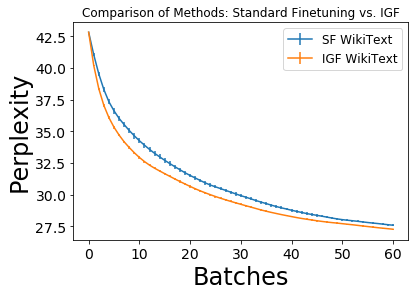

In [4]:
# This final cell plots the comparison between IGF and standard finetuning.
def preprocess(num, file, xmax,offset=0):
    runs = []
    xmin = 0
    for i in range(0+offset, num+offset):
        runs.append(joblib.load("eval_perps_" + str(i) + file))
    for ei, i in enumerate(runs):
        min_perp = 200
        new_run = []
        for ej, j in enumerate(np.array(i[:xmax+1])):
            new_run.append(min(min_perp,i[ej]))
            min_perp =  min(min_perp,i[ej])
        runs[ei] = new_run
    runs = np.array(runs)
    #print(runs)
    runs = np.vstack(runs)
    return runs

xmin = 0
xmax = 61
y = list(range(xmin,xmax))
runs_naive_wiki = preprocess(20, "sf_wiki.jbl", 61, offset=20)
runs_igf_wiki = preprocess(20, "igf_wiki.jbl", 61, offset=0)
y = list(range(xmin,xmax))
plt.errorbar(y, np.mean(np.array(runs_naive_wiki)[:,xmin:xmax], axis=0), yerr=np.std(runs_naive_wiki[:,xmin:xmax],axis=0) / np.sqrt(20), label='SF WikiText')
plt.errorbar(y, np.mean(np.array(runs_igf_wiki)[:,xmin:xmax], axis=0), yerr=np.std(runs_igf_wiki[:,xmin:xmax],axis=0) / np.sqrt(20), label='IGF WikiText')

y = list(range(xmin,xmax))
import scipy.stats
print("Difference of Means p-value at 60:", scipy.stats.ttest_ind(np.array(runs_naive_wiki)[:,60], np.array(runs_igf_wiki)[:,60], equal_var=False))
plt.xlabel("Batches", fontsize=24)
plt.ylabel("Perplexity", fontsize=24)
plt.title("Comparison of Methods: Standard Finetuning vs. IGF")
plt.tick_params(axis="x", labelsize=14)
plt.tick_params(axis="y", labelsize=14)
plt.legend(fontsize=12)